In [1]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Using TensorFlow backend.


# Load data 

In [2]:
reload(hp)

with open('../data/embeddings/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','crossref/exparser')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

for data_name in datasets:
    data[data_name] = data[data_name].fillna(0)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/crossref/exparser/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model

In [3]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/embeddings/glove-300.matrix.npy',
                        text_columns = ['author', 'title', 'journal'],
                        numeric_columns = ['year'],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=['cosine'],
                        text_compositions=['average'],
                        numeric_sim_metrics=['min_max_ratio', 'scaled_inverse_lp', 'unscaled_inverse_lp'],
                        dense_nodes=[32, 16, 8],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=True)

W0721 20:30:25.690151  9008 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0721 20:30:26.034388  9008 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0721 20:31:00.914971  9008 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0721 20:31:01.288368  9008 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0721 20:31:01.294053  9008 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backen

Number of inputs to dense layer: 14


# Train model 

In [4]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, batch_size=16384,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

W0721 20:33:16.180253  9008 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0721 20:33:16.304883  9008 deprecation.py:323] From D:\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1728716 samples, validate on 216089 samples
Epoch 1/10
1728716/1728716 [==============================] - 369s 214us/step - loss: 0.1351 - acc: 0.9897 - val_loss: 0.0458 - val_acc: 0.9897
Epoch 2/10
1728716/1728716 [==============================] - 282s 163us/step - loss: 0.0310 - acc: 0.9901 - val_loss: 0.0225 - val_acc: 0.9897
Epoch 3/10
1728716/1728716 [==============================] - 268s 155us/step - loss: 0.0181 - acc: 0.9901 - val_loss: 0.0156 - val_acc: 0.9897
Epoch 4/10
1728716/1728716 [==============================] - 257s 149us/step - loss: 0.0139 - acc: 0.9901 - val_loss: 0.0134 - val_acc: 0.9897
Epoch 5/10
1728716/1728716 [==============================] - 257s 148us/step - loss: 0.0124 - acc: 0.9954 - val_loss: 0.0121 - val_acc: 0.9973
Epoch 6/10
1728716/1728716 [==============================] - 255s 147us/step - loss: 0.0110 - acc: 0.9975 - val_loss: 0.0103 - val_acc: 0.9976
Epoch 7/10
1728716/1728716 [==============================] - 254s 147us/step - los

# Learning curves

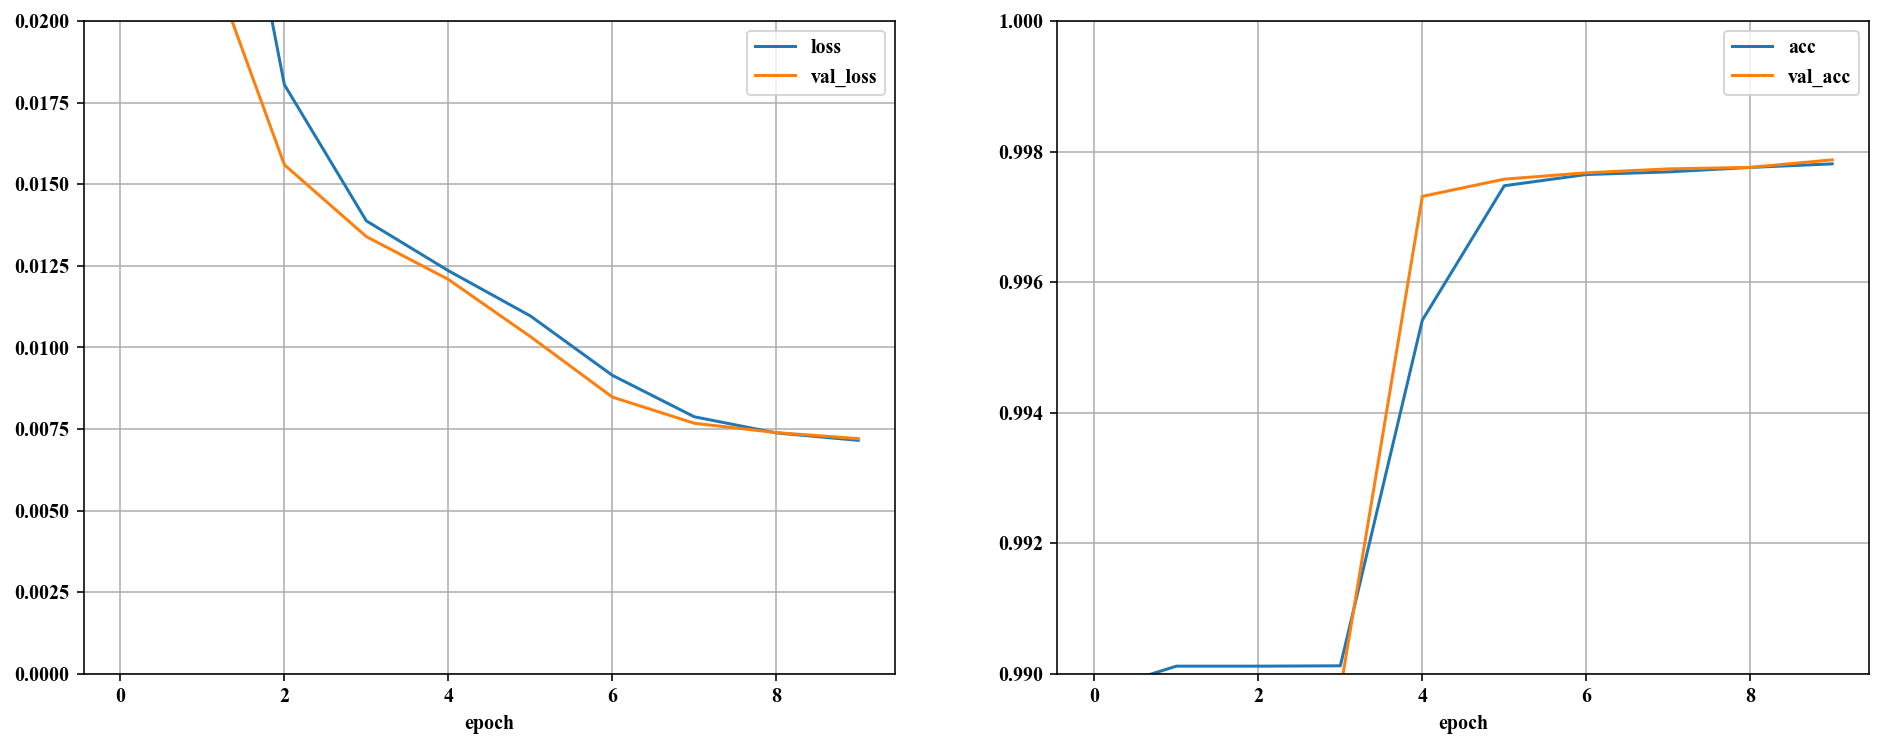

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[0].set_ylim(0, 0.02)
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')
axes[1].set_ylim(.99, 1)

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [6]:
y_val_pred = model.predict(X_val, batch_size=8192)[:,1]
y_val_ = data['val_y'].values.squeeze()
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    213859
           1       0.95      0.84      0.89      2230

   micro avg       1.00      1.00      1.00    216089
   macro avg       0.97      0.92      0.94    216089
weighted avg       1.00      1.00      1.00    216089

[[213761     98]
 [   361   1869]]


In [7]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & ~(y_val_pred >= 0.5)
columns = ['author', 'title', 'journal']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)
df_examine.sample(5)

,id1,author,title,journal,year,id2,author,title,journal,year
198605,3016a00a-abdf-11e9-af8b-04ea56df376a,Universal stress protein <unk> alters abundance of arginine and enhances intracellular survival by ATP binding in mycobacteria,"Jia , Q , Hu , X , Shi , D , Zhang , Y , Sun , M , Wang , J , Mi , K , Zhu , G","Scientific Reports [ Internet ] , 2017 March",0.0,301427ba-abdf-11e9-8258-04ea56df376a,Corrigendum : Universal Stress Protein <unk> Alters Abundance of Arginine and Enhances Intracellular Survival by ATP Binding in Mycobacteria,Jia,Scientific Reports,2017.0
51136,384c315c-abdf-11e9-bf1a-04ea56df376a,Talking About Literacy,"Mace , J.",( Aug,2003.0,384d696c-abdf-11e9-99a2-04ea56df376a,<unk>,Mace,<unk>,2003.0
102674,3284b094-abdf-11e9-9cec-04ea56df376a,<unk>,Nov,<unk>,1973.0,3285e88c-abdf-11e9-8874-04ea56df376a,<unk>,<unk>,<unk> Society of North <unk>,1973.0
115055,2db50b98-abdf-11e9-bfbf-04ea56df376a,"The sun , the Moon , and the Eyeball <unk> Cosmic <unk> ( 1996 ) Katachi <unk> Symmetry 63",Sugiura,<unk>,0.0,2db643c8-abdf-11e9-b1e7-04ea56df376a,"The sun , the Moon , and the Eyeball <unk> Cosmic Correspondence","Sugiura , K.",Katachi <unk> Symmetry,1996.0
123551,398e2d00-abdf-11e9-90d3-04ea56df376a,<unk>,<unk>,<unk>,2002.0,398d63b0-abdf-11e9-9e8a-04ea56df376a,<unk> <unk>,"Contents , P.",<unk>,2002.0


# Save model and histories 

In [8]:
pd.DataFrame(histories).to_csv('../data/histories/crossref-exparser.csv', index=False)
model.save_weights('../data/models/crossref-exparser-base-1-num-null')

# Test model 

In [9]:
model.load_weights('../data/models/crossref-exparser-base-1-num-null')
y_test_pred = model.predict(X_test, batch_size=8102)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5, digits=5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

              precision    recall  f1-score   support

           0    0.99841   0.99942   0.99891    214015
           1    0.93276   0.83566   0.88155      2075

   micro avg    0.99784   0.99784   0.99784    216090
   macro avg    0.96558   0.91754   0.94023    216090
weighted avg    0.99778   0.99784   0.99778    216090

[[213890    125]
 [   341   1734]]
